In [4]:
import copy

import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.ticker import ScalarFormatter

import numpy as np
import pandas as pd
import pickle as pkl
import re
from scipy.stats import spearmanr, pearsonr, rankdata

from sklearn import linear_model
from sklearn.metrics import mean_squared_error as mse
from sklearn.model_selection import train_test_split


from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

np.set_printoptions(linewidth=150)
pd.options.display.max_columns = 500
pd.options.mode.chained_assignment = None

# Parse Helpers

In [5]:
def line_format(line,add_quotes=True):
    if ("INFO" not in line or 'cell:' in line) and "[" in line and "]" in line:
        if "," not in line:
            if "." in line:
                line = re.sub('(?<=\d)\.+',",",line)
            else:
                line = re.sub('(?<=\d)\s+',",",line)
    if "torch.utils.data" in line:
        line = line.replace("<","'").replace(">","'")
            
            
    line = line.replace("\n","").replace(" ","").replace("array","np.array").replace("\e[1m","").replace("\e[21mN","")
    if add_quotes:
        if ":" in line:
            name,val = line.split(":",1)
            if name=='prefix':
                return '"{}":"{}"'.format(name.strip(),val)
            else:
                return '"{}":{}'.format(name.strip(),val)
    return line


def general_stats(line,current,start_cond,end_cond,stats_str):
    if start_cond in line:
        current = start_cond
        stats_str = line_format(line.split("stats:")[-1],False)
    elif current == start_cond:
        if end_cond in line:
            current = ''
            return True,"{}".format(stats_str),current

        else:
            stats_str += '{}'.format(line_format(line,False))
    return False,stats_str,current
            
def specific_stats(line,current,start_cond,end_cond,stats_str=""):
    #print(current,[(x,line,x in line) for x in end_cond])
    if start_cond in line:
        current = start_cond
        stats_str = ""
    
    elif current == start_cond:
        if any([x in line for x in end_cond]):
            current = ''
            return True,"{{{}}}".format(stats_str.rsplit(",",1)[0]),current
        elif line[-1]==",":
            #print("pre add ",stats_str)
            stats_str += '{}'.format(line_format(line.split("run:")[-1]))
            #print("post add",stats_str)
        else:
            #print("pre add ",stats_str)
            stats_str += '{}, '.format(line_format(line.split("run:")[-1]))
            #print("post add",stats_str)
    return False,stats_str,current

def local_exec(exec_str):
    ldict = {}
    exec("s={}".format(exec_str),globals(),ldict)
    return ldict['s']

# Parser

In [6]:
def parse(last=False):
    log1 = open("model_testbed.log","r").read()
    log2 = open("logs/model_testbed.log","r").read()
    log = log1+log2
    outs = log.split("NEW MODEL ")[1:]
    
    runs = []
    if last:
        outs = outs[-1:]
    for i,out in enumerate(outs):
        print(i,end="\r")
        curve = []
        predictions = []
        current = None
        time_taken = None
        max_val = None
        early_terminate=False
        stats_str = ""
        epoch_time = None
        run_date = None
        curve_update = False

        general_model_stats,general_run_stats,specific_model_stats,specific_run_stats = {},{},{},{}
        #print("--LOOP ENTER--")
        for line in out.split('\n'):
            if line=="" or ('Loss' in line and 'Corrects' not in line and 'Epoch: 0' not in line):
                curve_update=False
                pass
            else:
                finished,stats_str,current = general_stats(line,current,'Model stats:','Run stats:',stats_str)
                if finished:
                    general_model_stats = local_exec(stats_str)
                    stats_str, finished = "",False

                finished,stats_str,current = general_stats(line,current,'Run stats:','=====',stats_str)
                if finished:
                    general_run_stats= local_exec(stats_str)
                    stats_str, finished = "",False

                finished,stats_str,current = specific_stats(line,current,'-- Model stats',[' Run stats '],stats_str)
                if finished:
                    specific_model_stats= local_exec(stats_str)
                    stats_str, finished = "",False

                if not specific_run_stats:
                    finished,stats_str,current = specific_stats(line,current,' Run stats ',['====',"Per epoch","Run finished","Train Epoch: 0"],stats_str)
                    if finished:
                        specific_run_stats= local_exec(stats_str)
                        stats_str, finished = "",False

                #print(line,curve_update)
                if "Corrects" in line and not curve_update:
                    curve.append(int(line.split(":")[-1].split("/")[0]))
                    curve_update = True
                if "Prediction" in line:
                    if "[[" in line:
                        predictions.append(float(line.split("[[")[-1].split("]]")[0]))
                    elif "," in line:
                        predictions.append(float(line.split(":")[-1].split(",")[0]))
                    else:
                        predictions.append(float(line.split(":")[-1]))
                if "Time taken" in line:
                    time_taken = line.split(":")[-1]
                if "terminated" in line.lower():
                    early_terminate=True
                if 'Run started' in line:
                    run_date = line.split("at ")[-1]
                if 'Max corrects' in line:
                    max_val = int(line.split(":")[-1].split("/")[0])
                if 'Per epoch time' in line:
                    epoch_time = line.split(":")[-1].strip()
        #print("--LOOP EXIT--")

        stats = {}
        if general_run_stats:
            stats.update(general_run_stats)
        if general_model_stats:
            stats.update(general_model_stats)
        if specific_run_stats:
            stats.update(specific_run_stats)
        if specific_model_stats:
            stats.update(specific_model_stats)

        for key in stats.keys():
            new_key = key.strip().replace('matrix','matrices')
            #print(key)
            if key=='cell':
                new_key='cell_matrices'
            if key=='momemtum':
                new_key = 'momentum'
            if new_key!=key:
                stats[new_key] = stats.pop(key)

        stats['curve']=curve
        stats['predictions']=predictions
        stats['epoch']=len(curve)
        stats['time_taken']=time_taken
        stats['early_terminate']=early_terminate
        stats['per_epoch_time']=epoch_time
        if not max_val:
            stats['max']=max(curve) if len(curve)>0 else None
        else:
            stats['max']=max_val
        stats['run_date']=run_date
        runs.append(stats)

    run_stats = pd.DataFrame(runs)
    if not last:
        run_stats.to_pickle('run_stats.pkl')
    return run_stats
run_stats=parse()
run_stats.sort_values(by='max',ascending=False).iloc[0]

auxiliaries                                                      [2]
auxillaries                                                      NaN
cell_matrices      [[[0, 3, 0, 1], [0, 0, 13, 0], [0, 0, 0, 2], [...
cell_types         [1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, ...
curve              [5258, 5331, 6483, 7320, 7245, 7518, 7736, 813...
data                                                             NaN
drop_path                                                       True
early_terminate                                                False
epoch                                                            512
epochs                                                           512
log                                                             True
lr                                                              0.01
lr_schedule        {'type': 'cosine', 'lr_min': 1e-09, 'lr_max': ...
max                                                             9368
momentum                          

# Run Visualizations

## See all 512 Epoch Runs

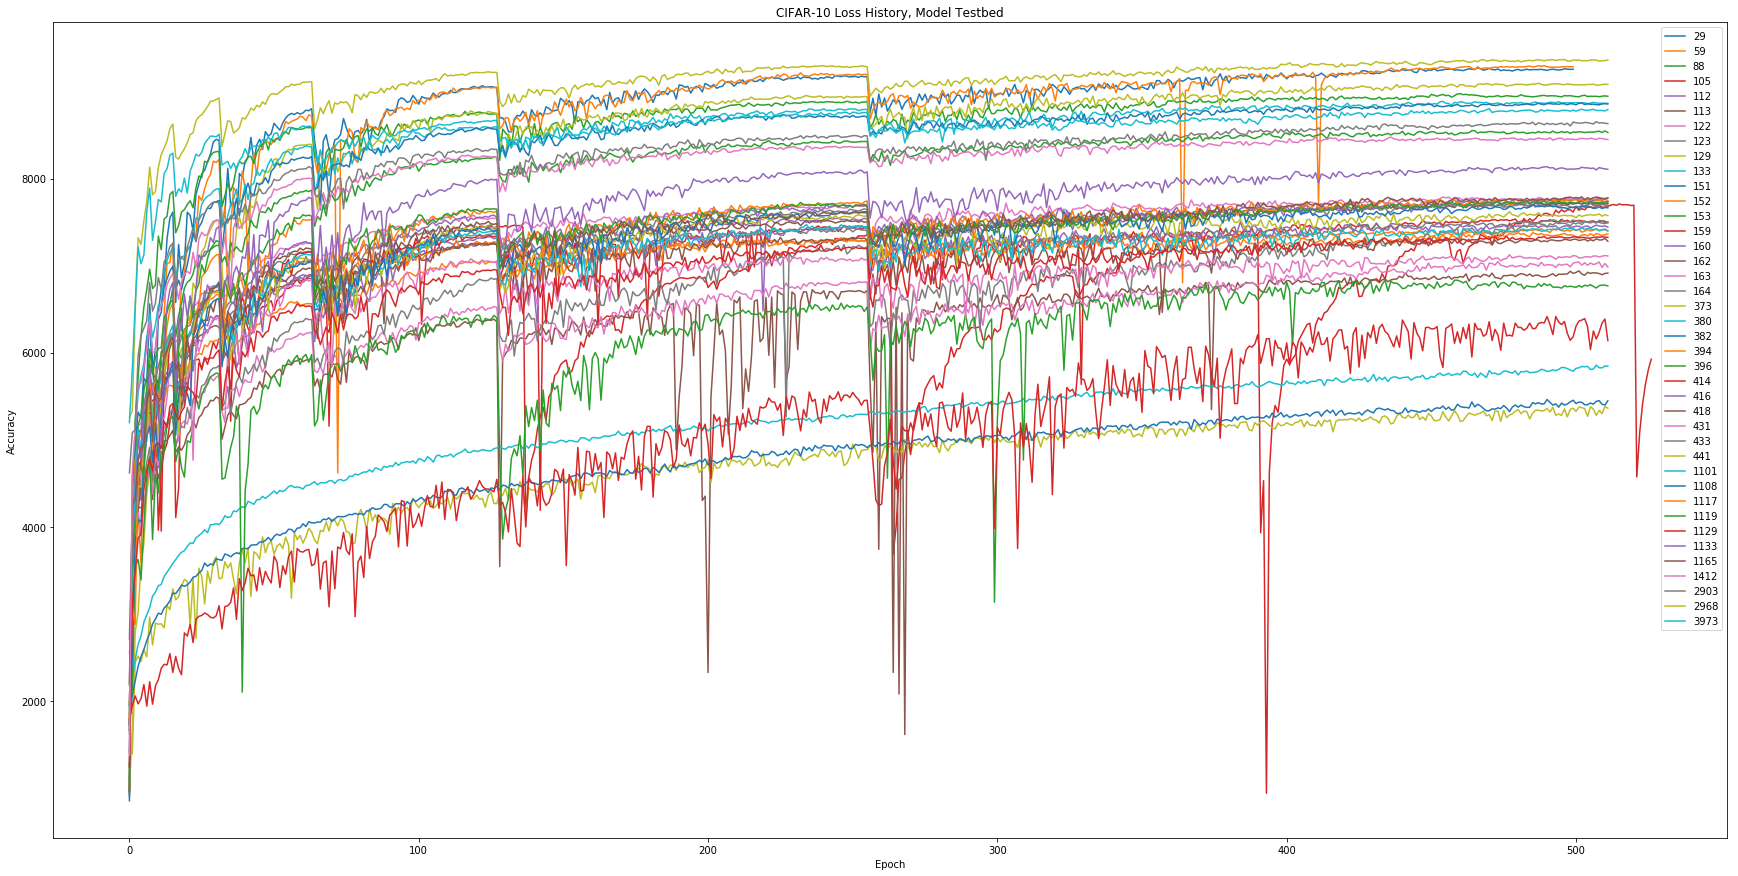

In [92]:
plt.figure(figsize=(30,15))
for i,curve in enumerate(run_stats['curve']):
    if len(curve)>=500:
        plt.plot(curve,label=i)
plt.title("CIFAR-10 Loss History, Model Testbed")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

## See latest run compared to best 512 runs

87


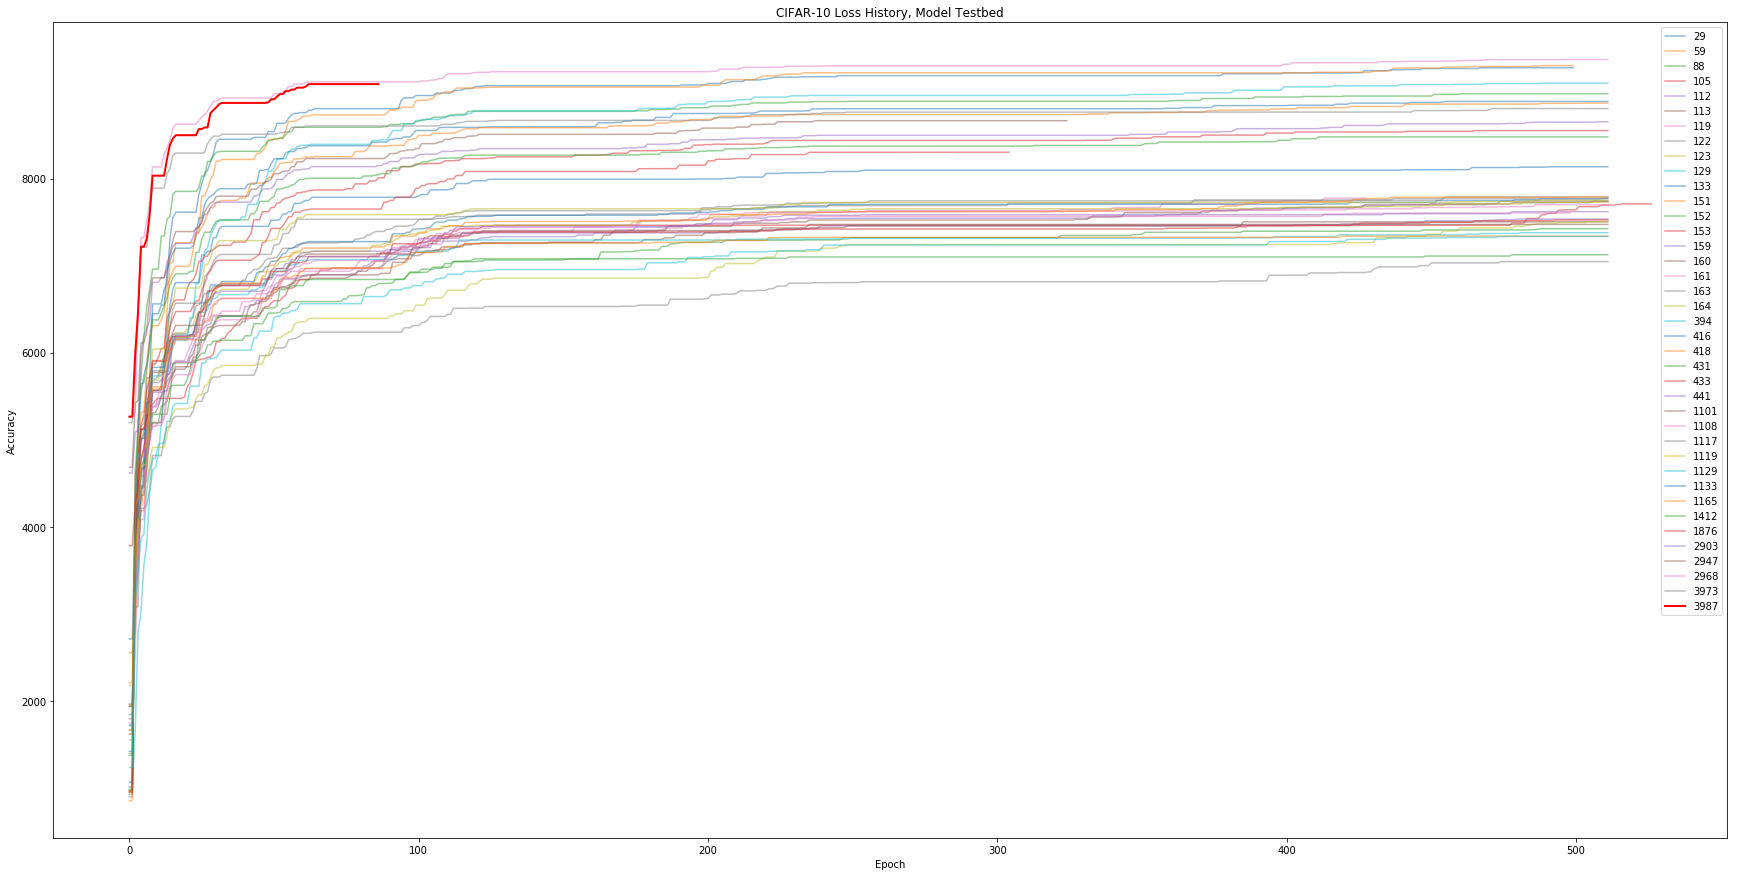

In [149]:
def cummax(arr):
    return [max(arr[:i]) if i>0 else arr[i] for i in range(len(arr))]

run_stats = run_stats.append(parse(last=True),sort=False)
plt.figure(figsize=(30,15))
best_runs = []
for i,curve in enumerate(run_stats['curve']):
    if 256<len(curve) and max(curve)>=7000:
        plt.plot(cummax(curve),label=i,alpha=.5)
        best_runs.append(curve)
    if i==len(run_stats)-1:
        print(len(curve))
        plt.plot(cummax(curve),label=i,linewidth=2,color='red')
        
plt.title("CIFAR-10 Loss History, Model Testbed")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

## See Change in Performance Rankings 

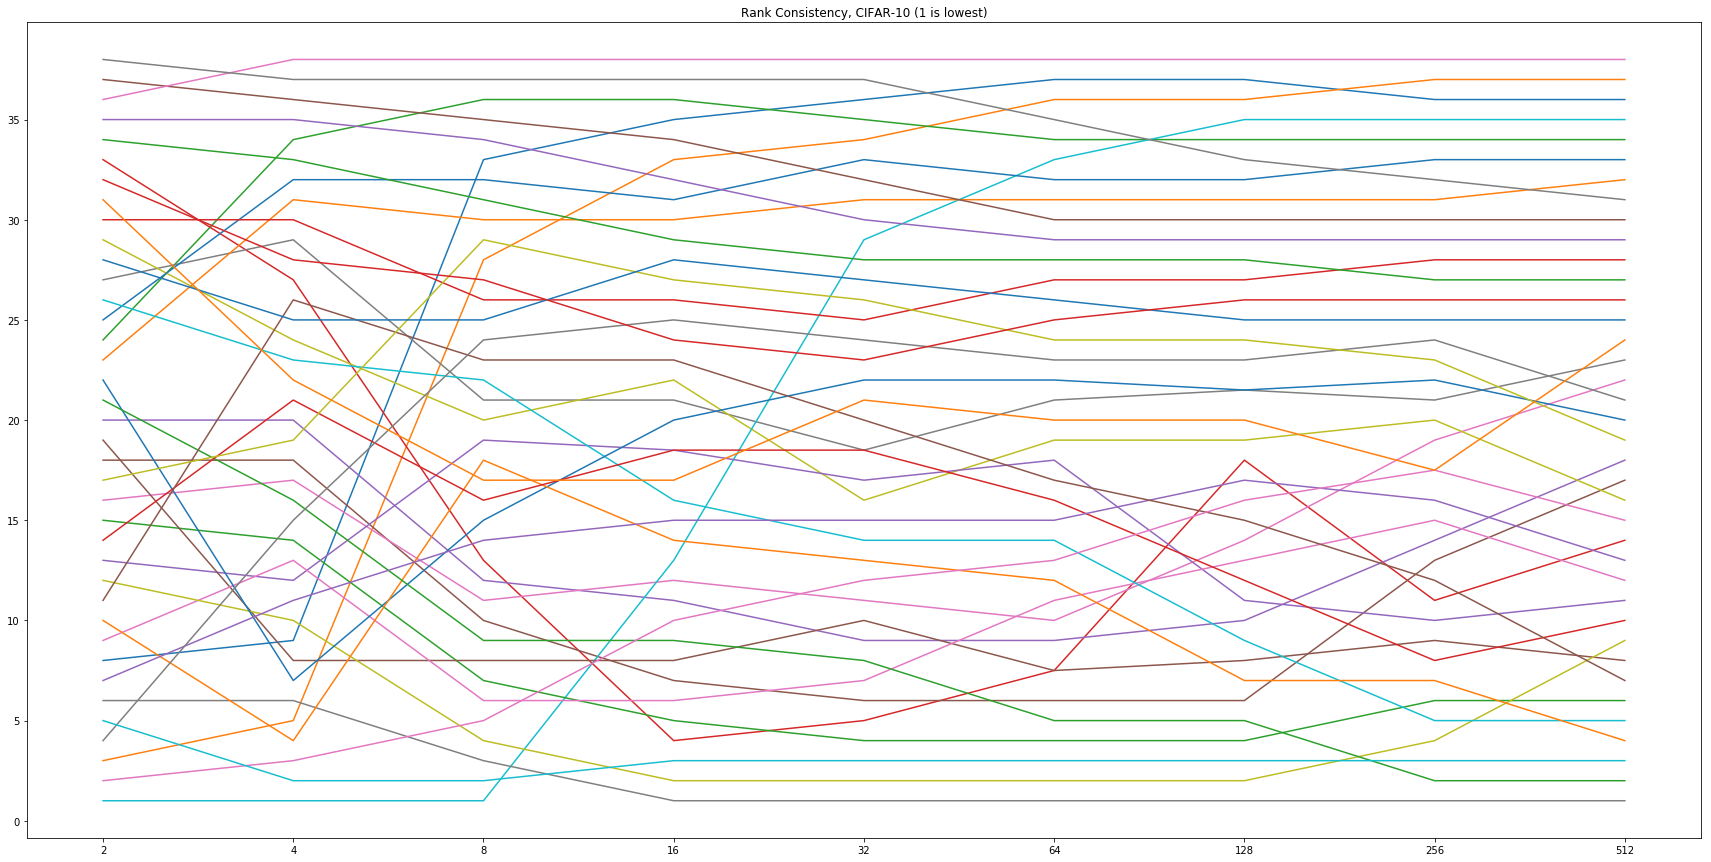

In [150]:
import scipy.stats as ss
from matplotlib.ticker import ScalarFormatter

plt.figure(figsize=(30,15))
ranks = []
for restart in [2**x for x in range(1,10)]:
    best = [max(best_run[:restart]) for best_run in best_runs]
    ranks.append(ss.rankdata(best))
    
plt.semilogx([2**x for x in range(1,10)],ranks,basex=2)
ax = plt.gca()
for axis in [ax.xaxis, ax.yaxis]:
    axis.set_major_formatter(ScalarFormatter())
plt.title("Rank Consistency, CIFAR-10 (1 is lowest)")
plt.show()

# Macro Train Predictors

In [95]:
predictor_df = parse()

def macro_process(predictor_df):
    losses = predictor_df[predictor_df['epoch']>=500].append(predictor_df.iloc[-1])
    losses['curve']=losses['curve'].apply(lambda x: x+[max(x)]*12 if len(x)==500 else x)
    losses['curve']=losses['curve'].apply(lambda x: x[:512] if len(x)>512 else x)
    losses['reductions']=losses['cell_types'].apply(sum)
    losses['parallel']=losses['cell_matrices'].apply(lambda x: len(x) if len(x)<3 else 1)
    losses['cells']=losses['cell_types'].apply(len)
    losses['nodes']=losses['cell_matrices'].apply(lambda x: len(x[0]) if len(x)<3 else len(x))
    losses['cell']=losses['cell_matrices'].apply(lambda x: np.array(x[0]) if len(x)<3 else np.array(x))
    losses['lr_max']=losses['lr_schedule'].apply(lambda x: x['lr_max'])
    losses['fill']=losses['cell'].apply(lambda x: len(np.triu(x).nonzero()[0])/x.size)

    losses = losses[losses['reductions']>4]
    for i in range(512):
        if i==0:
            losses['max_curve_{}'.format(i)]=losses['curve'].apply(lambda x:x[0])
        else:
            losses['max_curve_{}'.format(i)]=losses['curve'].apply(lambda x: max(x[:i+1]))
    return losses

losses = macro_process(predictor_df)
losses.to_pickle('macro_losses.pkl')
losses.iloc[:-1]

,auxiliaries,auxillaries,cell_matrices,cell_types,curve,data,drop_path,early_terminate,epoch,epochs,log,lr,lr_schedule,max,momentum,params,per_epoch_time,predictions,prefix,residual_cells,run_date,scale,scales,time_taken,track_progess,track_progress,verbose,weight_decay,reductions,parallel,cells,nodes,cell,lr_max,fill,max_curve_0,max_curve_1,max_curve_2,max_curve_3,max_curve_4,max_curve_5,max_curve_6,max_curve_7,max_curve_8,max_curve_9,max_curve_10,max_curve_11,max_curve_12,max_curve_13,max_curve_14,max_curve_15,max_curve_16,max_curve_17,max_curve_18,max_curve_19,max_curve_20,max_curve_21,max_curve_22,max_curve_23,max_curve_24,max_curve_25,max_curve_26,max_curve_27,max_curve_28,max_curve_29,max_curve_30,max_curve_31,max_curve_32,max_curve_33,max_curve_34,max_curve_35,max_curve_36,max_curve_37,max_curve_38,max_curve_39,max_curve_40,max_curve_41,max_curve_42,max_curve_43,max_curve_44,max_curve_45,max_curve_46,max_curve_47,max_curve_48,max_curve_49,max_curve_50,max_curve_51,max_curve_52,max_curve_53,max_curve_54,max_curve_55,max_curve_56,max_curve_57,max_curve_58,max_curve_59,max_curve_60,max_curve_61,max_curve_62,max_curve_63,max_curve_64,max_curve_65,max_curve_66,max_curve_67,max_curve_68,max_curve_69,max_curve_70,max_curve_71,max_curve_72,max_curve_73,max_curve_74,max_curve_75,max_curve_76,max_curve_77,max_curve_78,max_curve_79,max_curve_80,max_curve_81,max_curve_82,max_curve_83,max_curve_84,max_curve_85,max_curve_86,max_curve_87,max_curve_88,max_curve_89,max_curve_90,max_curve_91,max_curve_92,max_curve_93,max_curve_94,max_curve_95,max_curve_96,max_curve_97,max_curve_98,max_curve_99,max_curve_100,max_curve_101,max_curve_102,max_curve_103,max_curve_104,max_curve_105,max_curve_106,max_curve_107,max_curve_108,max_curve_109,max_curve_110,max_curve_111,max_curve_112,max_curve_113,max_curve_114,max_curve_115,max_curve_116,max_curve_117,max_curve_118,max_curve_119,max_curve_120,max_curve_121,max_curve_122,max_curve_123,max_curve_124,max_curve_125,max_curve_126,max_curve_127,max_curve_128,max_curve_129,max_curve_130,max_curve_131,max_curve_132,max_curve_133,max_curve_134,max_curve_135,max_curve_136,max_curve_137,max_curve_138,max_curve_139,max_curve_140,max_curve_141,max_curve_142,max_curve_143,max_curve_144,max_curve_145,max_curve_146,max_curve_147,max_curve_148,max_curve_149,max_curve_150,max_curve_151,max_curve_152,max_curve_153,max_curve_154,max_curve_155,max_curve_156,max_curve_157,max_curve_158,max_curve_159,max_curve_160,max_curve_161,max_curve_162,max_curve_163,max_curve_164,max_curve_165,max_curve_166,max_curve_167,max_curve_168,max_curve_169,max_curve_170,max_curve_171,max_curve_172,max_curve_173,max_curve_174,max_curve_175,max_curve_176,max_curve_177,max_curve_178,max_curve_179,max_curve_180,max_curve_181,max_curve_182,max_curve_183,max_curve_184,max_curve_185,max_curve_186,max_curve_187,max_curve_188,max_curve_189,max_curve_190,max_curve_191,max_curve_192,max_curve_193,max_curve_194,max_curve_195,max_curve_196,max_curve_197,max_curve_198,max_curve_199,max_curve_200,max_curve_201,max_curve_202,max_curve_203,max_curve_204,max_curve_205,max_curve_206,max_curve_207,max_curve_208,max_curve_209,max_curve_210,max_curve_211,max_curve_212,max_curve_213,max_curve_214,...,max_curve_262,max_curve_263,max_curve_264,max_curve_265,max_curve_266,max_curve_267,max_curve_268,max_curve_269,max_curve_270,max_curve_271,max_curve_272,max_curve_273,max_curve_274,max_curve_275,max_curve_276,max_curve_277,max_curve_278,max_curve_279,max_curve_280,max_curve_281,max_curve_282,max_curve_283,max_curve_284,max_curve_285,max_curve_286,max_curve_287,max_curve_288,max_curve_289,max_curve_290,max_curve_291,max_curve_292,max_curve_293,max_curve_294,max_curve_295,max_curve_296,max_curve_297,max_curve_298,max_curve_299,max_curve_300,max_curve_301,max_curve_302,max_curve_303,max_curve_304,max_curve_305,max_curve_306,max_curve_307,max_curve_308,max_curve_309,max_curve_310,max_curve_311,max_curve_312,max_curve_313,max_curve_314,max_curve_315,max_curve_316,max_cu

## Max by Epoch

In [96]:
all_macro_funcs = []
all_macro_metrics = []

for addition in [[]]:
    for test_run in range(50):
        train,test = train_test_split(losses[:-1],test_size=.25)
        print(test_run,end="\r")
        epoch_metrics = []
        funcs = {}
        for i in range(512):
            regr = linear_model.LinearRegression()

            column_selector=['max_curve_{}'.format(i),'params','parallel','cells','nodes','scale','lr_max']+addition
            train_X = train[column_selector]
            train_Y = train['max']

            test_X = test[column_selector]
            test_Y = test['max']

            regr = linear_model.LinearRegression()
            regr.fit(train_X,train_Y)
            x_func = regr.intercept_+np.dot(train_X,regr.coef_)
            pred = regr.intercept_+np.dot(test_X,regr.coef_)
            c95 = np.std(test_Y.values-pred)*1.96
            funcs[i]={'b':regr.intercept_,'m':regr.coef_,'95':c95,'coef_names':column_selector}

            metrics = {}
            metrics["Pearsonr"]=pearsonr(pred,test_Y)[0]
            metrics['c95']=int(c95)
            epoch_metrics.append(metrics)

            if addition and test_run==49 and not i%50:
                print("\n\n\n=={}==============================".format(i))
                xy_df = pd.DataFrame(test_X*regr.coef_)
                xy_df['intercept']=regr.intercept_
                xy_df['pred']=xy_df.apply(lambda x: int(sum(x)),1)
                xy_df['_score']=test_Y
                xy_df['%pts error']=(xy_df['_score']-xy_df['pred'])/100
                display(xy_df)
                #display(test)

                plt.subplot(121)
                plt.plot(pred,test_Y,".")
                plt.plot(pred,pred)
                plt.plot(pred,pred+c95,alpha=.5)
                plt.plot(pred,pred-c95,alpha=.5)
                plt.title("Test")

                plt.subplot(122)
                plt.plot(x_func,train_Y,".")
                plt.plot(x_func,x_func)
                plt.plot(x_func,x_func+c95,alpha=.5)
                plt.plot(x_func,x_func-c95,alpha=.5)
                plt.title("Train")
                plt.tight_layout()

                plt.show()
                print('\tIntercept:', regr.intercept_)
                print('\tCoefficients: \n\t', *["{}: {:.4f}".format(list(train_X)[i],x) for (i,x) in enumerate(regr.coef_)])
                print("\tPearsonR: {:.3f},{:.3f}".format(*pearsonr(x_func,train_Y)))
                print("\t95%: ±{:.2f}".format(c95))
        all_macro_metrics.append(epoch_metrics)
        all_macro_funcs.append(funcs)

    summaries = [[] for _ in range(512)]
    for epoch_metrics in all_macro_metrics:
        for i,epoch_metric in enumerate(epoch_metrics):
            summaries[i].append(epoch_metric)
    summary_dfs = [pd.DataFrame(x) for x in summaries]

    epoch_means = pd.DataFrame([summary_df.mean() for summary_df in summary_dfs])
    print(column_selector)
    display(epoch_means.loc[[2**x for x in range(0,9)]+[511]])

['max_curve_511', 'params', 'parallel', 'cells', 'nodes', 'scale', 'lr_max']


,Pearsonr,c95
1,0.739965,1254.26
2,0.807407,1079.64
4,0.840168,1012.44
8,0.896539,828.10
16,0.937173,674.50
32,0.960925,546.94
64,0.971471,462.02
128,0.980681,369.08
256,0.994236,197.90
511,1.000000,0.00


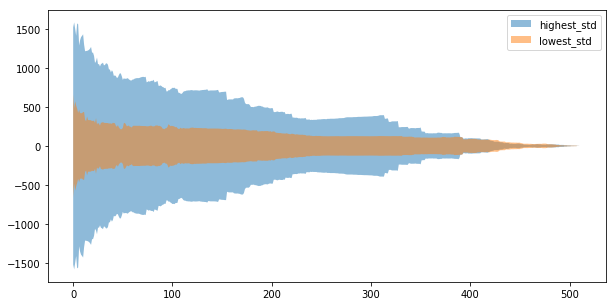

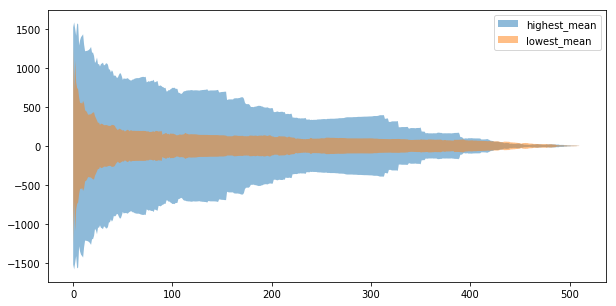

50


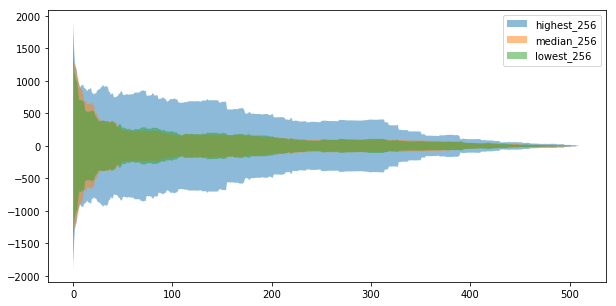

['max_curve_0', 'params', 'parallel', 'cells', 'nodes', 'scale', 'lr_max']


In [101]:
plt.figure(figsize=(10,5))
all_macro_funcs.sort(key=lambda x: np.std([x[i]['95'] for i in range(512)]))
maxes,mins = np.array([all_macro_funcs[-1][i]['95'] for i in range(512)]),np.array([all_macro_funcs[0][i]['95'] for i in range(512)])
plt.fill_between(range(512),-maxes,maxes,label="highest_std",alpha=.5)
plt.fill_between(range(512),-mins,mins,label="lowest_std",alpha=.5)
plt.legend()
plt.show()

plt.figure(figsize=(10,5))
all_macro_funcs.sort(key=lambda x: np.mean([x[i]['95'] for i in range(512)]))
maxes,mins = np.array([all_macro_funcs[-1][i]['95'] for i in range(512)]),np.array([all_macro_funcs[0][i]['95'] for i in range(512)])
plt.fill_between(range(512),-maxes,maxes,label="highest_mean",alpha=.5)
plt.fill_between(range(512),-mins,mins,label="lowest_mean",alpha=.5)
plt.legend()
plt.show()

plt.figure(figsize=(10,5))
n = len(all_macro_funcs)
print(n)
all_macro_funcs.sort(key=lambda x: x[256]['95'])
maxes,mins = np.array([all_macro_funcs[-1][i]['95'] for i in range(512)]),np.array([all_macro_funcs[0][i]['95'] for i in range(512)])
median = np.array([all_macro_funcs[n//50][i]['95'] for i in range(512)])
plt.fill_between(range(512),-maxes,maxes,label="highest_256",alpha=.5)
plt.fill_between(range(512),-median,median,label="median_256",alpha=.5)
plt.fill_between(range(512),-mins,mins,label="lowest_256",alpha=.5)
plt.legend()
plt.show()

print(all_macro_funcs[0][0]['coef_names'])
pkl.dump(all_macro_funcs[0],open('macro_loss_predictors.pkl',"wb"))

## Check Macro Predictions

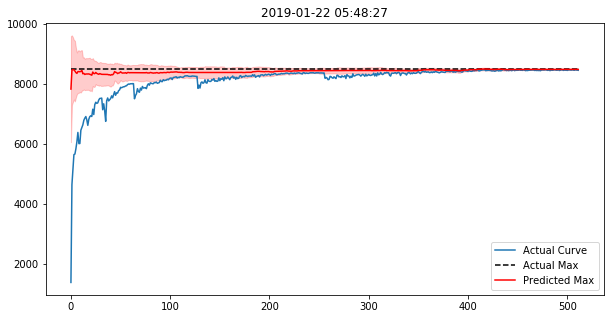

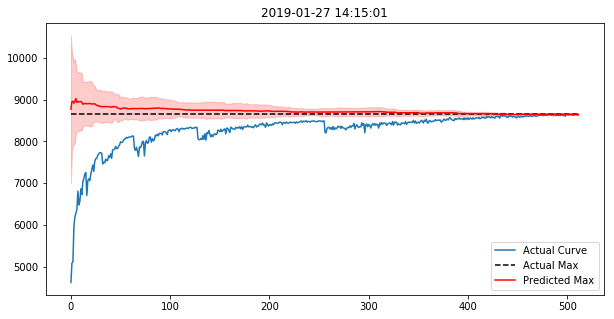

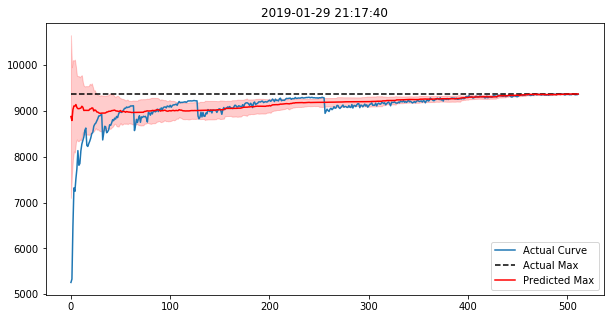

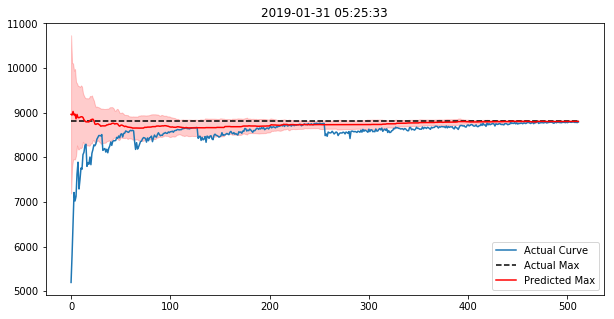

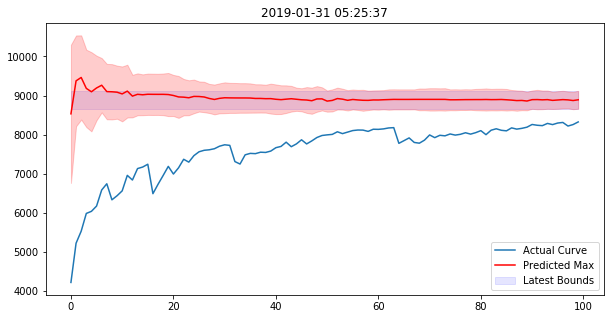

In [102]:
funcs = pkl.load(open('macro_loss_predictors.pkl',"rb"))

losses= macro_process(predictor_df.append(parse(last=True),sort=False))

for idx,row in list(losses.iloc[-5:].iterrows()):
    curve_len = len(row['curve'])
    plt.figure(figsize=(10,5))
    plt.plot(row['curve'],label='Actual Curve')
    preds = []
    for i in range(curve_len):
        X = row[['max_curve_{}'.format(i),'params','parallel','cells','nodes','scale','lr_max']]
        preds.append(funcs[i]['b']+np.dot(X,funcs[i]['m']))
    preds = np.array(preds)
    c95s = np.array([value['95'] for (key,value) in list(funcs.items())[:curve_len]])
    
    if curve_len==512:
        plt.plot([max(row['curve'])]*curve_len,label="Actual Max",color='black',linestyle='dashed')
    else:
        plt.fill_between(range(curve_len),(preds+c95s)[-1],(preds-c95s)[-1],color='blue',alpha=.1,label="Latest Bounds")
    
    plt.fill_between(range(curve_len),preds+c95s,preds-c95s,color='red',alpha=.2)

        
    plt.plot(preds,label="Predicted Max",color='red')
    
    
    plt.title(row['run_date'])
    plt.legend(loc='lower right')
    plt.show()

# Micro Train Predictors

In [144]:
micro_losses               = copy.copy(run_stats)
micro_losses               = micro_losses[micro_losses['cell_types'].apply(lambda x: x==[1,1])]
micro_losses               = micro_losses[micro_losses['curve'].apply(lambda x: len(x)>=8)]
micro_losses['cell_matrices']   = micro_losses['cell_matrices'].apply(lambda x: x if len(x)<3 else [x])
micro_losses['reductions'] = micro_losses['cell_types'].apply(sum)
micro_losses['curve']      = micro_losses['curve'].apply(lambda x: x[:8] if len(x)>8 else x)
micro_losses['parallel']   = micro_losses['cell_matrices'].apply(len)
micro_losses['cells']      = micro_losses['cell_types'].apply(len)
micro_losses['nodes']      = micro_losses['cell_matrices'].apply(lambda x: len(x[0]) if len(x)<3 else len(x))

for i in range(8):
    if i==0:
        micro_losses['max_curve_{}'.format(i)]=micro_losses['curve'].apply(lambda x:x[0])
        micro_losses['max_increase_{}'.format(i)]=micro_losses['curve'].apply(lambda x: 1)
    else:
        micro_losses['max_curve_{}'.format(i)]=micro_losses['curve'].apply(lambda x: max(x[:i+1]))
        micro_losses['max_increase_{}'.format(i)]=micro_losses['max_curve_{}'.format(i)]-micro_losses['max_curve_{}'.format(0)]
        
micro_losses.to_pickle('micro_losses.pkl')
micro_losses.iloc[0:10]

,auxiliaries,auxillaries,cell_matrices,cell_types,curve,data,drop_path,early_terminate,epoch,epochs,log,lr,lr_schedule,max,momentum,params,per_epoch_time,predictions,prefix,residual_cells,run_date,scale,scales,time_taken,track_progess,track_progress,verbose,weight_decay,reductions,parallel,cells,nodes,max_curve_0,max_increase_0,max_curve_1,max_increase_1,max_curve_2,max_increase_2,max_curve_3,max_increase_3,max_curve_4,max_increase_4,max_curve_5,max_increase_5,max_curve_6,max_increase_6,max_curve_7,max_increase_7
52,NaN,NaN,"[[[0, 9, 9, 15, 2, 0], [0, 0, 14, 0, 13, 5], [...","[1, 1]","[4482, 5538, 4659, 5930, 6327, 6035, 6970, 7195]",NaN,NaN,False,10,500.0,True,0.01,"{'type': 'cosine', 'lr_min': 0, 'lr_max': 0.01...",7195.0,0.9,61108.0,None,[],NaN,NaN,2018-10-31 14:18:34,2.0,"(2.0, 0.5)",None,NaN,NaN,True,0.0001,2,1,2,6,4482,1,5538,1056,5538,1056,5930,1448,6327,1845,6327,1845,6970,2488,7195,2713
57,NaN,NaN,"[[[0, 9, 9, 15, 2, 0], [0, 0, 14, 0, 13, 5], [...","[1, 1]","[4888, 5242, 6200, 6538, 6707, 7089, 6278, 7460]",NaN,True,False,10,10.0,True,0.01,"{'type': 'cosine', 'lr_min': 0, 'lr_max': 0.01...",7460.0,0.9,61108.0,None,[],NaN,NaN,2018-10-31 14:29:41,2.0,"(2.0, 0.5)","3 min, 29 s",NaN,NaN,True,0.0001,2,1,2,6,4888,1,5242,354,6200,1312,6538,1650,6707,1819,7089,2201,7089,2201,7460,2572
64,NaN,NaN,"[[[0, 9, 9, 15, 2, 0], [0, 0, 14, 0, 13, 5], [...","[1, 1]","[4629, 5455, 5651, 5207, 5188, 4589, 5942, 6620]",NaN,True,False,10,10.0,True,0.01,"{'type': 'cosine', 'lr_min': 0, 'lr_max': 0.01...",6620.0,0.9,68020.0,None,[],NaN,NaN,2018-11-01 15:11:10,2.0,"[(2.0, 0.5), (2.0, 0.5)]","8 min, 42 s",NaN,NaN,True,0.0001,2,2,2,6,4629,1,5455,826,5651,1022,5651,1022,5651,1022,5651,1022,5942,1313,6620,1991
82,NaN,NaN,"[[[0.0, 8.0, 0.0, 6.0, 4.0], [0.0, 0.0, 13.0, ...","[1, 1]","[4707, 4309, 5021, 5670, 5688, 6307, 6582, 6779]",NaN,True,False,10,10.0,True,0.01,"{'type': 'cosine', 'lr_min': 0, 'lr_max': 0.01...",7075.0,0.9,44926.0,None,[],NaN,NaN,2018-11-02 15:10:08,2.0,"[(2.0, 0.5)]","1 min, 49 s",NaN,NaN,True,0.0001,2,1,2,5,4707,1,4707,0,5021,314,5670,963,5688,981,6307,1600,6582,1875,6779,2072
92,NaN,NaN,"[[[0, 11, 11, 5, 11], [0, 0, 0, 0, 13], [0, 0,...","[1, 1]","[936, 4499, 4847, 4875, 5102, 5225, 5356, 5367]",NaN,True,False,10,10.0,True,NaN,"{'type': 'cosine', 'lr_min': 0, 'lr_max': 0.00...",5434.0,0.9,22282.0,None,[],NaN,NaN,2018-11-05 14:19:52,2.0,"(2.0, 0.5)","1 min, 39 s",NaN,NaN,True,0.0001,2,1,2,5,936,1,4499,3563,4847,3911,4875,3939,5102,4166,5225,4289,5356,4420,5367,4431
93,NaN,NaN,"[[[0, 11, 11, 5, 11], [0, 0, 0, 0, 13], [0, 0,...","[1, 1]","[721, 4513, 4872, 5036, 5217, 5354, 5447, 5418]",NaN,True,True,9,10.0,True,NaN,"{'type': 'cosine', 'lr_min': 0, 'lr_max': 0.00...",5481.0,0.9,22282.0,None,[],NaN,NaN,2018-11-05 14:23:06,2.0,"(2.0, 0.5)","1 min, 34 s",NaN,NaN,True,0.0001,2,1,2,5,721,1,4513,3792,4872,4151,5036,4315,5217,4496,5354,4633,5447,4726,5447,4726
94,NaN,NaN,"[[[0, 11, 11, 5, 11], [0, 0, 0, 0, 13], [0, 0,...","[1, 1]","[1063, 4403, 4942, 5101, 5321, 5409, 5421, 5560]",NaN,True,False,10,10.0,True,NaN,"{'type': 'cosine', 'lr_min': 0, 'lr_max': 0.00...",5587.0,0.9,22282.0,None,[],NaN,NaN,2018-11-05 14:26:53,2.0,"(2.0, 0.5)","1 min, 36 s",NaN,NaN,True,0.0001,2,1,2,5,1063,1,4403,3340,4942,3879,5101,4038,5321,4258,5409,4346,5421,4358,5560,4497
95,NaN,NaN,"[[[0, 11, 11, 5, 11], [0, 0, 0, 0, 13], [0, 0,...","[1, 1]","[915, 4525, 4886, 5110, 5207, 5236, 5392, 5344]",NaN,True,False,10,10.0,True,NaN,"{'type': 'cosine', 'lr_min': 0, 'lr_max': 0.00...",5459.0,0.9,22282.0,None,[],NaN,NaN,2018-11-05 14:28:50,2.0,"(2.0, 0.5)","1 min, 41 s",NaN,NaN,True,0.0001,2,1,2,5,915,1,4525,3610,4886,3971,5110,4195,5207,4292,5236,4321,5392,4477,5392,4477
96,NaN,NaN,"[[[0, 11, 11, 5, 11], [0, 0, 0, 0, 13], [0, 0,...","[1, 1]","[923, 4321, 4768, 5034, 5108, 5244, 5402, 5479]",NaN,True,False,10,10.0,True,NaN,"{'type': 'cosine', 'lr_min': 0, 'lr_max': 0.00...",5556.0,0.9,22282.0,None,[],NaN,NaN,2018-11-05 14:32:20,2.0,"(2.0, 0.5)","1 min, 38 s",NaN,NaN,Tr

In [145]:
def top_n(arr):
    return sorted(enumerate(arr),key=lambda x: x[1],reverse=True)

In [146]:
verbose = True

for delta in [True]:
    all_metrics = []
    all_funcs  = []
    for test_run in range(100):
        if 0:#:test_run==99:
            verbose=True
        else:
            verbose=False
        train,test = train_test_split(micro_losses,test_size=100/len(micro_losses))
        funcs = {}
        spearmans,pearsons,errors,top_25s = [],[],[],[]
        epoch_metrics = []
        for i in range(8):
            regr = linear_model.LinearRegression()

            if not delta:
                selector = ['max_curve_{}'.format(i),'params','reductions','parallel','cells','nodes']
            else:
                selector = ['max_curve_{}'.format(j) for j in range(0,i+1)]
                selector += ['params','reductions','parallel','cells','nodes']
            
            train_X = train[selector]
            train_Y = train['max']

            test_X = test[selector]
            test_Y = test['max']


            regr = linear_model.LinearRegression()
            regr.fit(train_X,train_Y)
            x_func = regr.intercept_+np.dot(train_X,regr.coef_)
            pred = regr.intercept_+np.dot(test_X,regr.coef_)
            c95 = np.std(test_Y.values-pred)*1.96
            funcs[i]={'b':regr.intercept_,'m':regr.coef_,'95':c95,'coef_names':selector}

            if verbose:
                print(selector)
                print("\n\n\n==Epoch {}==============================".format(i))
                print("Train/test sizes: {}, {}".format(len(train_X),len(test_X)))
                xy_df = pd.DataFrame(test_X*regr.coef_)
                xy_df['intercept']=regr.intercept_
                xy_df['pred']=xy_df.apply(lambda x: int(sum(x)),1)
                xy_df['_score']=test_Y
                xy_df['%pts error']=(xy_df['_score']-xy_df['pred'])/100
                #display(xy_df)
                test['%pts error']=xy_df['%pts error']
                test['pred']=xy_df['pred']
                if i==2:
                    displayer = test[test['%pts error'].apply(lambda x: np.abs(x)<.5 or np.abs(x)>3)]
                    #display(displayer.sort_values(by='%pts error'))

                plt.subplot(121)
                plt.plot(pred,test_Y,".")
                plt.plot(pred,pred,alpha=.5)
                plt.plot(pred,pred+c95,alpha=.5)
                plt.plot(pred,pred-c95,alpha=.5)
                plt.xlabel("Predicted Score")
                plt.ylabel("Actual Score")
                plt.title("Test")

                plt.subplot(122)
                plt.plot(x_func,train_Y,".")
                plt.plot(x_func,x_func,alpha=.5)
                plt.plot(x_func,x_func+c95,alpha=.5)
                plt.plot(x_func,x_func-c95,alpha=.5)
                plt.xlabel("Predicted Score")
                plt.ylabel("Actual Score")
                plt.title("Train")
                plt.tight_layout()

                plt.show()
                print('Intercept:', regr.intercept_)
                print('Coefficients: \n', *["{}: {:.4f}".format(list(train_X)[i],x) for (i,x) in enumerate(regr.coef_)])
            
            top_tests = top_n(test_Y.values)
            top_preds = top_n(pred)   
            top_test_set = set([x[0] for x in top_tests[:25]])
            top_pred_set = set([x[0] for x in top_preds[:25]])
            
            metrics = {}
            metrics["Pearson Correlation"]=pearsonr(x_func,train_Y)[0]
            metrics["Spearman Rank Correlation"]=spearmanr(pred,test_Y)[0]
            metrics["95% Confidence"]=c95                              
            metrics["Actual Top-5 in Pred Top-5"] = len([1 for test_val in top_tests[:5] if test_val[0] in [pred[0] for pred in top_preds[:5]]])/5.
            metrics["Actual Top-5 in Preds"] = len([1 for x in top_tests[:5] if x[0] in top_pred_set])/5.
            metrics["Actual Top-10 in Preds"] = len([1 for x in top_tests[:10] if x[0] in top_pred_set])/10.
            metrics["Actual Top-20 in Preds"]=len([1 for x in top_tests[:20] if x[0] in top_pred_set])/20.
            metrics["Actual Top-25 in Preds"]=len([1 for x in top_tests[:25] if x[0] in top_pred_set])/25.
            metrics["Actual Bottom-50 in Preds"]=len([1 for x in top_tests[50:] if x[0] in top_pred_set])/50.
            
            epoch_metrics.append(metrics)
            
            if verbose:
                for key, value in metrics.items():
                    print(key,":",value)
                
                plt.plot(range(len(top_tests)),range(len(top_tests)),alpha=.5)
                plt.plot(range(len(top_tests)),[[test[0] for test in top_tests].index(x[0]) for x in top_preds],".")
                plt.xlabel("Predicted Rank")
                plt.ylabel("Actual Rank")
                plt.show()
         
        all_funcs.append(funcs)
        all_metrics.append(epoch_metrics)
        
    summaries = [],[],[],[],[],[],[],[]
    for epoch_metrics in all_metrics:
        for i,epoch_metric in enumerate(epoch_metrics):
            summaries[i].append(epoch_metric)
    summary_dfs = [pd.DataFrame(x) for x in summaries]
    
    epoch_means = pd.DataFrame([summary_df.mean() for summary_df in summary_dfs])
    print(selector)
    display(epoch_means)
        

all_funcs.sort(key=lambda x: x[3]['95'])
pkl.dump(all_funcs[0],open('micro_loss_predictors.pkl',"wb"))



['max_curve_0', 'max_curve_1', 'max_curve_2', 'max_curve_3', 'max_curve_4', 'max_curve_5', 'max_curve_6', 'max_curve_7', 'params', 'reductions', 'parallel', 'cells', 'nodes']


,95% Confidence,Actual Bottom-50 in Preds,Actual Top-10 in Preds,Actual Top-20 in Preds,Actual Top-25 in Preds,Actual Top-5 in Pred Top-5,Actual Top-5 in Preds,Pearson Correlation,Spearman Rank Correlation
0,1036.687486,0.1598,0.752,0.5430,0.4832,0.828,0.944,0.694081,0.298500
1,609.373174,0.0446,0.872,0.6890,0.6344,0.848,0.962,0.913461,0.759471
2,449.695230,0.0168,0.905,0.7770,0.7152,0.850,0.996,0.955090,0.838075
3,323.228787,0.0050,0.933,0.8525,0.7904,0.888,0.980,0.977242,0.904497
4,258.732494,0.0004,0.962,0.8625,0.8052,0.884,0.998,0.986083,0.935198
5,179.226656,0.0000,0.983,0.9050,0.8396,0.908,1.000,0.993211,0.959489
6,122.342494,0.0000,0.999,0.9500,0.8872,0.906,1.000,0.997048,0.979486
7,31.292831,0.0000,1.000,0.9995,0.9892,0.986,1.000,0.999735,0.998699


## Check Micro Predictions

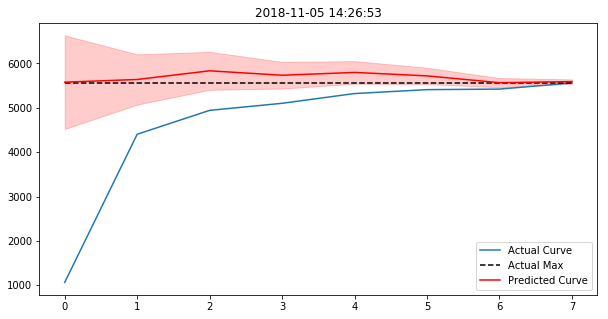

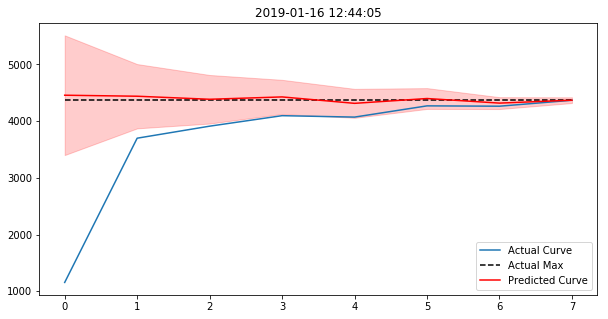

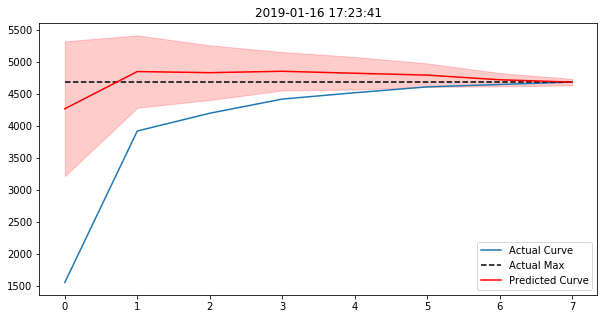

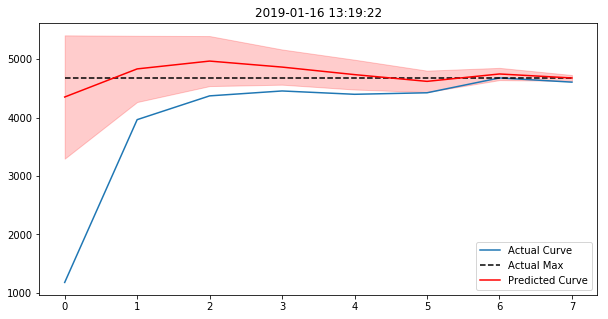

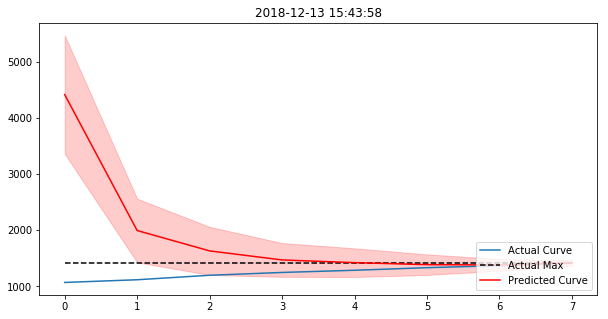

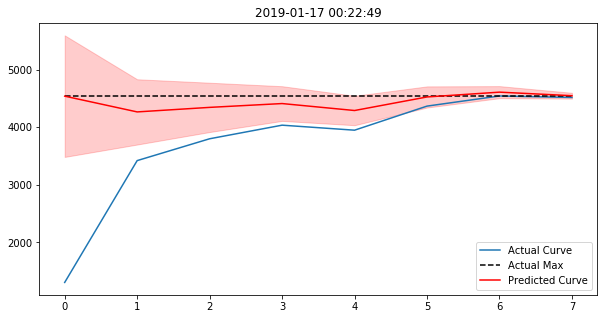

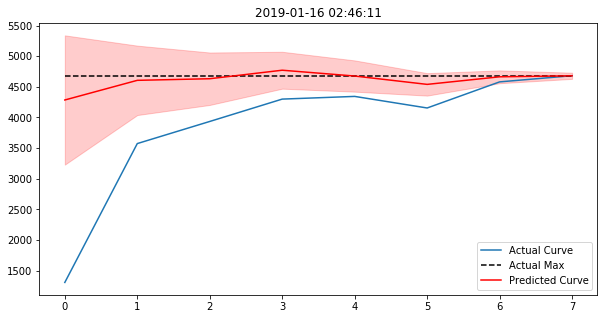

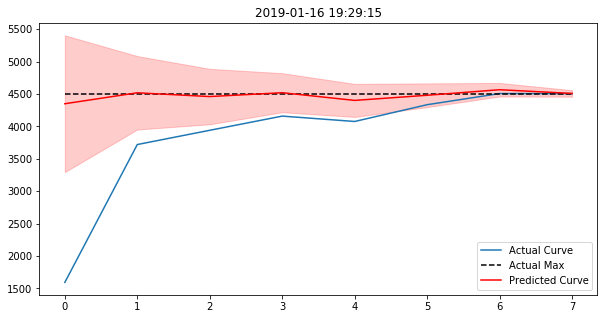

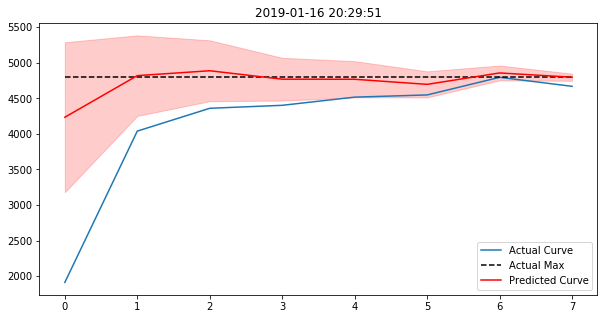

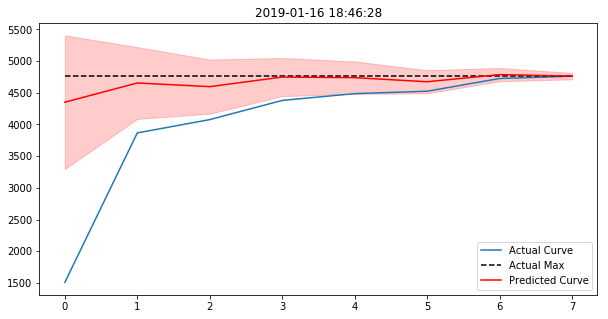

In [191]:
funcs = pkl.load(open('micro_loss_predictors.pkl',"rb"))
c95s = np.array([value['95'] for (key,value) in funcs.items()])

for idx,row in list(micro_losses.sample(10).iterrows()):
    plt.figure(figsize=(10,5))
    plt.plot(row['curve'],label='Actual Curve')
    preds = []
    for i in range(len(row['curve'])):
        X = row[['max_curve_{}'.format(i),'params','reductions','parallel','cells','nodes']]
        preds.append(funcs[i]['b']+np.dot(X,funcs[i]['m']))
    preds = np.array(preds)
    plt.fill_between(range(len(row['curve'])),preds+c95s,preds-c95s,color='red',alpha=.2)
    
    plt.plot([max(row['curve'])]*len(row['curve']),label="Actual Max",color='black',linestyle='dashed')
    plt.plot(preds,label="Predicted Curve",color='red')
    
    plt.title(row['run_date'])
    plt.legend(loc='lower right')
    plt.show()

# See Micro/Macro Correlation

In [7]:
matrices = {}

run_stats=parse()
for idx,row in run_stats.iterrows():
    if not type(row['cell_matrices'])==float:
        if len(row['cell_matrices'])>1:
            cell_matrix = np.array(row['cell_matrices'][0])
        else:
            cell_matrix = np.array(row['cell_matrices'])

        if matrices.get(cell_matrix.tobytes()) is None:
            matrices[cell_matrix.tobytes()] = []
        matrices[cell_matrix.tobytes()].append(row)
matrix_dfs = [pd.DataFrame(matrices[x]) for x in matrices.keys()]

display(matrix_dfs[-5])

,auxiliaries,auxillaries,cell_matrices,cell_types,curve,data,drop_path,early_terminate,epoch,epochs,log,lr,lr_schedule,max,momentum,params,per_epoch_time,predictions,prefix,residual_cells,run_date,scale,scales,time_taken,track_progess,track_progress,verbose,weight_decay
3959,NaN,NaN,"[[[0.0, 1.0, 15.0, 0.0], [0.0, 0.0, 5.0, 5.0],...","[1, 1]","[4200, 4952, 4966]",NaN,True,False,3,3.0,True,0.01,"{'type': 'cosine', 'lr_min': 1e-05, 'lr_max': ...",4966.0,0.9,7898.0,7.96 s,"[4011.0, 5812.0, 5627.0]","IncubatingCell988:n:4,c:0.58,m:0,id:IreneBrand...",NaN,2019-01-30 17:58:41,2.0,"(2.0, 0.5)",27.13 s,NaN,True,False,0.0001


In [14]:
pairs = []
matrix_id=0

print(len(matrix_dfs))
no_micro,no_macro = 0,0
for matrix_df in matrix_dfs:
    micro_scores,macro_scores = [],[]
    micro_stats,macro_stats = [],[]
    micro,macro=False,False
    
    cell_counts = []
    for idx,row in matrix_df.iterrows():
        if len(row['cell_types'])==2 and len(row['curve'])>=8:
            micro_scores.append(row['curve'][-1])
            micro_stats.append(dict(("micro_"+k,v) for (k,v) in row.items()))
            micro=True
        elif sum(row['cell_types'])==5 and len(row['curve'])==512:
            macro_scores.append(max(row['curve']))
            macro_stats.append(dict(("macro_"+k,v) for (k,v) in row.items()))
            macro=True
    if macro and not micro:
        no_micro +=1
    if micro and not macro:
        no_macro +=1
    if micro and macro:
        matrix_id+=1
    
    for i,micro in enumerate(micro_scores):
        for j,macro in enumerate(macro_scores):
            pair_dict = {"_score_micro":micro,"_score_macro":macro,"_matrix_id":matrix_id}
            pair_dict.update(micro_stats[i])
            pair_dict.update(macro_stats[j])
            pairs.append(pair_dict)
            
pair_df = pd.DataFrame(pairs)
pair_df['micro_reductions']=pair_df['micro_cell_types'].apply(sum)
pair_df['macro_reductions']=pair_df['macro_cell_types'].apply(sum)
pair_df['micro_cells']=pair_df['micro_cell_types'].apply(len)
pair_df['macro_cells']=pair_df['macro_cell_types'].apply(len)
pair_df['macro_spacing']=(pair_df['macro_cells']-pair_df['macro_reductions'])/(pair_df['macro_reductions']-1)


pair_df['nodes']=pair_df['macro_cell_matrices'].apply(lambda x: len(x[0]))
pair_df['micro_delta']=pair_df['micro_curve'].apply(lambda x: max(x)-x[0])
pair_df['macro_parallel']=pair_df['macro_cell_matrices'].apply(len)
pair_df['macro_lr_max']=pair_df['macro_lr_schedule'].apply(lambda x: x['lr_max'])
pair_df.to_pickle('pair_losses.pkl')
print(no_micro,no_macro,matrix_id)

pair_df=pair_df[pair_df['macro_run_date'].apply(lambda x: '2019' in x)]
pair_df

2651
1 596 25


,_matrix_id,_score_macro,_score_micro,macro_auxiliaries,macro_auxillaries,macro_cell_matrices,macro_cell_types,macro_curve,macro_data,macro_drop_path,macro_early_terminate,macro_epoch,macro_epochs,macro_log,macro_lr,macro_lr_schedule,macro_max,macro_momentum,macro_params,macro_per_epoch_time,macro_predictions,macro_prefix,macro_residual_cells,macro_run_date,macro_scale,macro_scales,macro_time_taken,macro_track_progess,macro_track_progress,macro_verbose,macro_weight_decay,micro_auxiliaries,micro_auxillaries,micro_cell_matrices,micro_cell_types,micro_curve,micro_data,micro_drop_path,micro_early_terminate,micro_epoch,micro_epochs,micro_log,micro_lr,micro_lr_schedule,micro_max,micro_momentum,micro_params,micro_per_epoch_time,micro_predictions,micro_prefix,micro_residual_cells,micro_run_date,micro_scale,micro_scales,micro_time_taken,micro_track_progess,micro_track_progress,micro_verbose,micro_weight_decay,micro_reductions,macro_reductions,micro_cells,macro_cells,macro_spacing,nodes,micro_delta,macro_parallel,macro_lr_max
18,5,7125,4275,NaN,NaN,"[[[0.0, 1.0, 10.0], [1.0, 0.0, 1.0], [1.0, 0.0...","[1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1]","[1938, 3803, 4392, 4677, 4556, 4845, 5032, 529...",NaN,True,False,512,512.0,True,0.01,"{'type': 'cosine', 'lr_min': 1e-05, 'lr_max': ...",7125.0,0.9,814154.0,30.25 s,"[7873.0, 8009.0, 8037.0, 7999.0, 7939.0, 7842....",Macro,NaN,2019-01-14 14:34:21,5.0,"(2.0, 0.5)","4 hrs, 33 mins, 28 s",NaN,True,False,0.0001,NaN,NaN,"[[[0.0, 1.0, 10.0], [1.0, 0.0, 1.0], [1.0, 0.0...","[1, 1]","[1190, 3649, 3814, 3946, 3473, 4139, 4118, 4275]",NaN,False,False,8,8.0,True,0.01,"{'type': 'cosine', 'lr_min': 1e-05, 'lr_max': ...",4275.0,0.9,5872.0,7.42 s,"[7955.0, 7971.0, 7722.0, 7583.0, 7468.0, 7310....",Micro,NaN,2019-01-14 10:00:53,2.0,"(2.0, 0.5)","1 min, 7 s",NaN,True,False,0.0001,2,5,2,13,2.0,3,3085,2,0.010
19,5,7125,4468,NaN,NaN,"[[[0.0, 1.0, 10.0], [1.0, 0.0, 1.0], [1.0, 0.0...","[1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1]","[1938, 3803, 4392, 4677, 4556, 4845, 5032, 529...",NaN,True,False,512,512.0,True,0.01,"{'type': 'cosine', 'lr_min': 1e-05, 'lr_max': ...",7125.0,0.9,814154.0,30.25 s,"[7873.0, 8009.0, 8037.0, 7999.0, 7939.0, 7842....",Macro,NaN,2019-01-14 14:34:21,5.0,"(2.0, 0.5)","4 hrs, 33 mins, 28 s",NaN,True,False,0.0001,NaN,NaN,"[[[0.0, 1.0, 10.0], [1.0, 0.0, 1.0], [1.0, 0.0...","[1, 1]","[1228, 3751, 3992, 3953, 4094, 4251, 4399, 4468]",NaN,True,False,8,8.0,True,0.01,"{'type': 'cosine', 'lr_min': 1e-05, 'lr_max': ...",4468.0,0.9,5872.0,7.03 s,"[4425.0, 4511.0, 4483.0, 4327.0, 4346.0, 4412....","IncubatingCell50:n:3,c:0.299,m:0,id:MadonnaRio...",NaN,2019-01-16 19:30:20,2.0,"(2.0, 0.5)","1 min, 4 s",NaN,True,False,0.0001,2,5,2,13,2.0,3,3240,2,0.010
20,5,7125,4481,NaN,NaN,"[[[0.0, 1.0, 10.0], [1.0, 0.0, 1.0], [1.0, 0.0...","[1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1]","[1938, 3803, 4392, 4677, 4556, 4845, 5032, 529...",NaN,True,False,512,512.0,True,0.01,"{'type': 'cosine', 'lr_min': 1e-05, 'lr_max': ...",7125.0,0.9,814154.0,30.25 s,"[7873.0, 8009.0, 8037.0, 7999.0, 7939.0, 7842....",Macro,NaN,2019-01-14 14:34:21,5.0,"(2.0, 0.5)","4 hrs, 33 mins, 28 s",NaN,True,False,0.0001,NaN,NaN,"[[[0.0, 1.0, 10.0], [1.0, 0.0, 1.0], [1.0, 0.0...","[1, 1]","[1307, 3746, 4092, 4261, 4354, 4428, 4496, 4481]",NaN,True,False,8,8.0,True,0.01,"{'type': 'cosine', 'lr_min': 1e-05, 'lr_max': ...",4496.0,0.9,5872.0,7.10 s,"[4411.0, 4507.0, 4586.0, 4608.0, 4617.0, 4592....","IncubatingCell238:n:3,c:0.717,m:0,id:LeoPercyB...",NaN,2019-01-16 23:48:29,2.0,"(2.0, 0.5)","1 min, 4 s",NaN,True,False,0.0001,2,5,2,13,2.0,3,3189,2,0.010
21,5,7125,4187,NaN,NaN,"[[[0.0, 1.0, 10.0], [1.0, 0.0, 1.0], [1.0, 0.0...","[1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1]","[1938, 3803, 4392, 4677, 4556, 4845, 5032, 529...",NaN,True,False,512,512.0,True,0.01,"{'type': 'cosine', 'lr_min': 1e-05, 'lr_max': ...",7125.0,0.9,814154.0,30.25 s,"[7873.0, 8009.0, 8037.0, 7999.0, 7939.0, 7842....",Macro,NaN,2019-01-14 14:34:21,5.0,"(2.0, 0.5)","4 hrs, 33 mins, 28 s",NaN,True,False,

Train/Test: 33 11
Intercept: 1276.6579080117563
Coefficients: 
 macro_reductions: 0.0000 macro_spacing: 786.7991 macro_scale: 578.6107 macro_parallel: 282.5483 _score_micro: -0.2093 micro_params: 0.0395 nodes: 160.9774 micro_delta: 0.3522


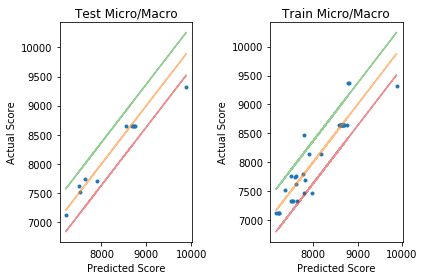

Pearson:  0.93,p=1.186700700865379e-14
Spearman: 0.92,p=7.138340757089676e-14
95%: ±367.20
Train/Test Pearsons:  0.834, 0.834
Train/Test Spearmans: 0.794, 0.794
Error: 650.5844958332084


In [23]:
verbose = False

errors = []
test_pearsons,test_spearmans = [],[]
train_pearsons,train_spearmans = [],[]

for test_run in range(100):
    selector = ['macro_reductions','macro_spacing','macro_scale','macro_parallel','_score_micro','micro_params','nodes']
    pair_df['micro_delta']=pair_df['micro_curve'].apply(lambda x: x[-1])-pair_df['micro_curve'].apply(lambda x: x[0])
    selector += ['micro_delta']
    
    train,test = train_test_split(pair_df,test_size=.25)     
    train_X,test_X = train[selector],test[selector]
    train_Y,test_Y = train['_score_macro'],test['_score_macro']

    regr = linear_model.LinearRegression()
    regr.fit(train_X,train_Y)
    
    x_func = regr.intercept_+np.dot(train_X,regr.coef_)
    pred   = regr.intercept_+np.dot(test_X,regr.coef_)
    c95  = np.std(test_Y.values-pred)*1.96
    func ={'b':regr.intercept_,'m':regr.coef_,'95':c95,'coef_names':selector}
    pearson = pearsonr(x_func,train_Y)
    
    train_pearsons.append(pearsonr(x_func,train_Y)[0])
    test_pearsons.append(pearsonr(pred,test_Y)[0])
    train_spearmans.append(spearmanr(x_func,train_Y)[0])
    test_spearmans.append(spearmanr(pred,test_Y)[0])
    errors.append(c95)
    
    if verbose or test_run==99:
        print("Train/Test:",len(train),len(test))
        print('Intercept:', regr.intercept_)
        print('Coefficients: \n', *["{}: {:.4f}".format(list(train_X)[i],x) for (i,x) in enumerate(regr.coef_)])
        plt.subplot(121)
        plt.plot(pred,test_Y,".")
        plt.plot(pred,pred,alpha=.5)
        plt.plot(pred,pred+c95,alpha=.5)
        plt.plot(pred,pred-c95,alpha=.5)
        plt.xlabel("Predicted Score")
        plt.ylabel("Actual Score")
        plt.title("Test Micro/Macro")

        plt.subplot(122)
        plt.plot(x_func,train_Y,".")
        plt.plot(x_func,x_func,alpha=.5)
        plt.plot(x_func,x_func+c95,alpha=.5)
        plt.plot(x_func,x_func-c95,alpha=.5)
        plt.xlabel("Predicted Score")
        plt.ylabel("Actual Score")
        plt.title("Train Micro/Macro")
        plt.tight_layout()

        plt.show()

        print("Pearson:  {:.2f},p={}".format(*pearson))
        print("Spearman: {:.2f},p={}".format(*spearmanr(x_func,train_Y)))
        print("95%: ±{:.2f}".format(c95))

print("Train/Test Pearsons:  {:.3f}, {:.3f}".format(np.mean(test_pearsons),np.mean(test_pearsons)))
print("Train/Test Spearmans: {:.3f}, {:.3f}".format(np.mean(test_spearmans),np.mean(test_spearmans)))
print("Error:",np.median(errors))
pkl.dump(func,open('pair_predictors.pkl',"wb"))

In [ ]:
mac